#Library

In [1]:
import os
import cv2
import pdb
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import preprocess_input

# Q2



## Try to limit the count of sliding windows

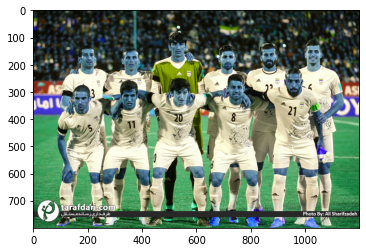

In [2]:
path = "/content/Melli.jpg"
image = cv2.imread(path)
plt.imshow(image)

In [3]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clh = clahe.apply(gray)

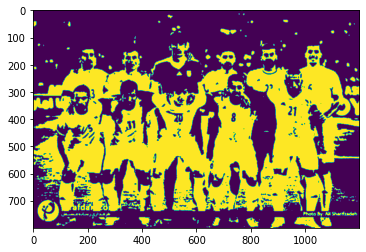

In [ ]:
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
thresh = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)[1]

plt.imshow(thresh)

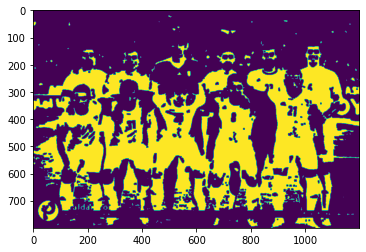

In [ ]:
str_elem = np.ones((5, 5))
eroded = cv2.erode(thresh ,str_elem.astype('uint8') , iterations=1)
plt.imshow(eroded)

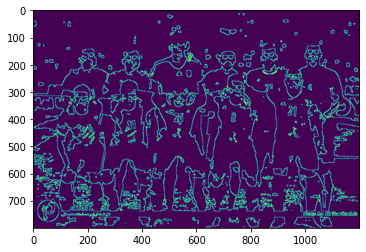

In [ ]:
ksize = 3
gX = cv2.Sobel(thresh, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=ksize)
gY = cv2.Sobel(thresh, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=ksize)

gX = cv2.convertScaleAbs(gX)
gY = cv2.convertScaleAbs(gY)

combined = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)
plt.imshow(combined)

## Sliding window

In [4]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [ ]:
image.shape

(800, 1200, 3)

In [11]:
import time
(winW, winH) = (128, 128)

suggested = []

for (x, y, window) in sliding_window(image, stepSize=32, windowSize=(winW, winH)):
  # if the window does not meet our desired window size, ignore it
  if window.shape[0] != winH or window.shape[1] != winW:
    continue

  box = (x, y, x + winW, y + winH )
  
  suggested.append(box)

In [12]:
len(suggested)

748

## Get annotations

In [42]:
int(float('321.92'))

321

In [52]:
import xml.etree.ElementTree as ET

tree = ET.parse("/content/annotations.xml")

root = tree.getroot()

faces = []

# iterate news items
for item in root.findall('./image/box'):
  faces.append(
      (
        int(float(item.attrib['ytl'])), 
        int(float(item.attrib['xtl'])), 
        int(float(item.attrib['ybr'])),
        int(float(item.attrib['xbr'])) 
      )
  )
len(faces)

11

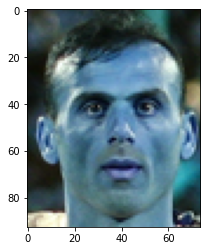

In [22]:
plt.imshow(image[134:227, 321:395])

## Computing IoU

In [13]:
def intersection_over_union(boxA, boxB):

	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	
	iou = interArea / float(boxAArea + boxBArea - interArea)
	
	return iou

In [88]:
result = []


for boxA in suggested : 
  for boxB in faces: 
    iou = intersection_over_union(boxA, boxB)

    if iou >= .4 :
      region = image[boxA[0]:boxA[2], boxA[1]:boxA[3]]
      time.sleep(0.025)

      result.append((boxA, 'face'))
    else :
      result.append((boxA, 'background'))

In [89]:
len(result)

8228

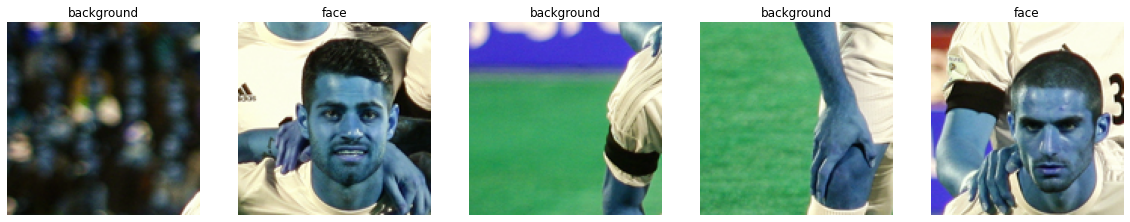

In [95]:
image = cv2.imread("/content/Melli.jpg")
f, axarr = plt.subplots(1, 5, figsize=(20, 100))

random_indexes = [45, 7939, 123, 554 ,1215]

for i in range(len(random_indexes)):
  box = result[random_indexes[i]][0]

  axarr[i].imshow(image[box[0]:box[2],box[1]:box[3]])
  axarr[i].set_title(result[random_indexes[i]][1])
  axarr[i].axis('off')

plt.show()

#Prepare dataset

##donwload

In [ ]:
!wget http://adas.cvc.uab.es/s2uad/Download/KITTI_SEMANTIC.zip

--2023-01-15 17:37:01--  http://adas.cvc.uab.es/s2uad/Download/KITTI_SEMANTIC.zip
Resolving adas.cvc.uab.es (adas.cvc.uab.es)... 158.109.8.54
Connecting to adas.cvc.uab.es (adas.cvc.uab.es)|158.109.8.54|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114312538 (109M) [application/zip]
Saving to: ‘KITTI_SEMANTIC.zip’

KITTI_SEMANTIC.zip  100%[===================>] 109.02M  3.64MB/s    in 15s     

2023-01-15 17:37:16 (7.34 MB/s) - ‘KITTI_SEMANTIC.zip’ saved [114312538/114312538]



In [ ]:
!unzip -q "/content/KITTI_SEMANTIC.zip"

##define generator

In [ ]:
kitti_classes = {
    'Building':   [128, 0,   0],
    'Vegetation': [128, 128, 0],
    'Sky':        [128, 128, 128],
    'Car':        [64,  0,   128],
    'Sign':       [192, 128, 128],
    'Road':       [128, 64,  128],
    'Pedestrian': [64,  64,  0],
    'Fence':      [64,  64,  128],
    'Pole':       [192, 192, 128],
    'Sidewalk':   [0,   0,   192],
    'Cyclist':    [0,   128, 192],
}

class DataGenerator(keras.utils.Sequence):
    def __init__(self, path, batch_size=1, shuffle=True, subset='train'):
        self.path = path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.subset = subset

        rgb_path = path + '/RGB/'
        gt_path = path + '/GT/'

        self.images = []
        self.segments = []
        for name in np.sort(os.listdir(rgb_path)):
            rgb_name = rgb_path + name
            gt_name = gt_path + name

            rgb = cv2.imread(rgb_name)
            rgb = cv2.resize(rgb, (128,128))
            gt = cv2.imread(gt_name)
            gt = cv2.resize(gt, (128,128))
            gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

            labels = np.zeros(gt.shape[:2])
            for i, (key, value) in enumerate(kitti_classes.items()):
              labels[np.sum(gt == value, axis=2) == 3] = i+1

            mask = labels == 0
            labels = keras.utils.to_categorical(labels-1, num_classes=len(kitti_classes))
            labels[mask==1, :] = 0

            self.images.append(rgb)
            self.segments.append(labels)

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))


    def __getitem__(self, index):
        image = self.images[index]
        segment = self.segments[index]

        d0 = np.mod(image.shape[0], 16)
        d1 = np.mod(image.shape[1], 16)

        image = image[d0:, d1:, :]
        segment = segment[d0:, d1:, :]

        if self.subset == 'train':
            if np.random.uniform() > 0.5:
                image = cv2.flip(image, 1)
                segment = cv2.flip(segment, 1)
        return np.expand_dims(image, axis=0), np.expand_dims(segment, axis=0)

    # Updates indices after each epoch
    def on_epoch_end(self):
        self.indices = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

train_generator = DataGenerator('/content/KITTI_SEMANTIC/Training_00')
valid_generator = DataGenerator('/content/KITTI_SEMANTIC/Validation_07', shuffle=False, subset='valid')

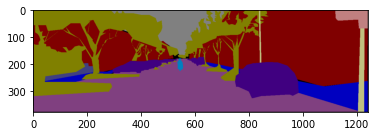

In [ ]:
gt = cv2.imread('/content/KITTI_SEMANTIC/Training_00/GT/000000.png')
gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
plt.imshow(gt)

In [ ]:
labels = np.zeros(gt.shape[:2])
for i, (key, value) in enumerate(kitti_classes.items()):
  labels[np.sum(gt == value, axis=2) == 3] = i+1

mask = labels == 0
labels = keras.utils.to_categorical(labels-1, num_classes=len(kitti_classes))
labels[mask==1, :] = 0

In [ ]:
np.sum(labels == 4) / np.sum(labels >= 0)

0.0

#Define Architecture

<font color='red'>**Questions**</font>

1-what's the effect of padding is equal same? What's another value for padding?

2- explain the affection of activation function.

3- explain the affection of using kernel_initializer in layers.

In [ ]:
def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

<font color='red'>**Questions**</font>

4- explain what's the difference between Conv2DTranspose and Conv2D.

In [ ]:
def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)

   return x

<font color='red'>**Questions**</font>

5- explain downsample_block, double_conv_block and upsample_block functions.

In [ ]:
def build_unet_model(): 
   inputs = layers.Input(shape=(128,128,3))
   f1, p1 = downsample_block(inputs, 64)
   f2, p2 = downsample_block(p1, 128)
   f3, p3 = downsample_block(p2, 256)
   f4, p4 = downsample_block(p3, 512)
   bottleneck = double_conv_block(p4, 1024)
   u6 = upsample_block(bottleneck, f4, 512)
   u7 = upsample_block(u6, f3, 256)
   u8 = upsample_block(u7, f2, 128)
   u9 = upsample_block(u8, f1, 64)
   outputs = layers.Conv2D(11, 1, padding="valid", activation = "softmax")(u9)
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [ ]:
unet_model = build_unet_model()

<font color='red'>**Attention**</font>

* Before seeing the result of the following cell, try to compute the parameters of each layer, that's useful!

In [ ]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

#Train Model

<font color='red'>**Questions**</font>

6- why use an optimizer in learning?

7- why use compile function?

8- why are we select categorical_crossentropy in the loss of function?


In [ ]:
unet_model.compile(optimizer=keras.optimizers.Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_generator.segments[0].shape

(128, 128, 11)

In [ ]:
unet_model.outputs[0].shape

TensorShape([None, 128, 128, 11])

<font color='red'>**Questions**</font>

9 - explain earlystopping function

10 - explain different between fit and compile functions in Keras 

11- explain the difference between batch and epoch


In [ ]:

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0,
                                               patience=5,
                                               restore_best_weights=True)

# Train model on dataset
history = unet_model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=100,
                    callbacks=[early_stopping])

Epoch 1/100
100/100 [==============================] - 14s 75ms/step - loss: 78.8504 - accuracy: 0.1860 - val_loss: 36.2186 - val_accuracy: 0.3131
Epoch 2/100
100/100 [==============================] - 6s 64ms/step - loss: 42.4515 - accuracy: 0.2382 - val_loss: 26.5311 - val_accuracy: 0.3218
Epoch 3/100
100/100 [==============================] - 6s 59ms/step - loss: 31.0965 - accuracy: 0.2505 - val_loss: 22.0838 - val_accuracy: 0.3257
Epoch 4/100
100/100 [==============================] - 6s 58ms/step - loss: 23.8444 - accuracy: 0.2599 - val_loss: 17.9379 - val_accuracy: 0.3322
Epoch 5/100
100/100 [==============================] - 6s 57ms/step - loss: 18.9398 - accuracy: 0.2699 - val_loss: 14.5791 - val_accuracy: 0.3359
Epoch 6/100
100/100 [==============================] - 6s 57ms/step - loss: 15.3541 - accuracy: 0.2757 - val_loss: 11.7276 - val_accuracy: 0.3416
Epoch 7/100
100/100 [==============================] - 6s 58ms/step - loss: 12.7323 - accuracy: 0.2747 - val_loss: 8.9744 -

#Inference

In [ ]:
def deisplay_prediction(x,y_prediction):
  color_dict = {0:(255,0,0),1:(0,0,255),2:(0,255,0),3:(128,128,128),4:(128,0,0),5:(0,128,0),6:(0,0,128),7:(255,255,255),8:(0,0,0),9:(128,255,128),10:(255,128,255)}
  fig = plt.figure()    
  plt.subplot(1, 2, 1)  
  plt.title("original image")  
  plt.imshow(x)
  prediction_image = x
  flag = 0
  for row in range(y_prediction[0].shape[0]):
    for column in range(y_prediction[0].shape[1]):
      prediction_image[row][column][:] = color_dict[np.argmax(y_prediction[0,row,column,:])]
  plt.subplot(1, 2, 2)
  plt.title("segmented image")
  plt.imshow(prediction_image)
  plt.show()
  # return prediction_image    

      

1/1 [==============================] - 0s 261ms/step


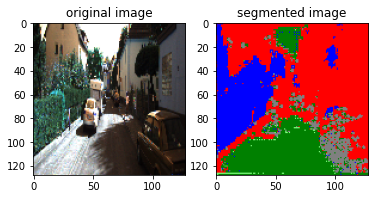

In [ ]:
X, Y_true = valid_generator.__getitem__(20)
deisplay_prediction(X[0],unet_model.predict(X))
